### Preprocessing - Skewness Correction - CNN with Classification

*This module is designed to correct skewness using OpenCV + DL

Approach
* FFT for Feature Detection
* CNN

Note:
For this purpose, I have used a publicly available Kaggle dataset ("Noisy and Rotated Scanned Documents"). The objective of choosing this dataset is because it has labelled data. I want to use supervised CNN for detecting angles and eventually compare the accuracy with the computer vision approach. Finally, all models will be applied to Input Data created using Course Descriptor.

### Connect to Google Drive

Google drive contains the input data created using Course Descriptor

In [ ]:
# Connect Google Drive
from google.colab import drive
drive.mount('/content/gdrive/', force_remount=True)

Mounted at /content/gdrive/


### Load Data from Kaggle

In [ ]:
# Downloading dataset is not required.
# Dataset is downloaded and available via G Drive
'''
!pip install opendatasets
import opendatasets as od

od.download("https://www.kaggle.com/datasets/sthabile/noisy-and-rotated-scanned-documents?select=scan_doc_rotation")
'''

'\n!pip install opendatasets\nimport opendatasets as od\n\nod.download("https://www.kaggle.com/datasets/sthabile/noisy-and-rotated-scanned-documents?select=scan_doc_rotation")\n'

### Import Libraries

In [ ]:
# Helper libraries
import os
import numpy as np
import cv2
from PIL import Image
import json
from matplotlib import pyplot as plt
import pandas as pd
import random
import matplotlib.pyplot as plt
import seaborn as sns


# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization
from keras.models import load_model
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

from skimage.io import imread, imsave
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_curve, roc_auc_score

from skimage.restoration import denoise_tv_chambolle

!pip install pyyaml h5py

### Global Parameters

In [ ]:
# Global Parameters

# Kaggle dataset parameters
root = '/content/gdrive/MyDrive/OWR/data/Kaggle/noisy-and-rotated-scanned-documents/scan_doc_rotation'
image_paths = os.path.join(root, 'images')
label_paths = os.path.join(root, 'labels')
tilted_root = '/content/gdrive/MyDrive/OWR/data/Kaggle/noisy-and-rotated-scanned-documents-tilted/scan_doc_rotation'
tilted_T_image_paths = os.path.join(tilted_root, 'images_T')
tilted_image_paths = os.path.join(tilted_root, 'images')
model_path = '/content/gdrive/MyDrive/OWR/dl_models'
model_mlp = 'skew_mlp_clas.h5'
model_cnn = 'skew_cnn_clas.h5'
#model_cnn_mobilenet = 'skew_mobilenet_clas.h5'
tilted_model_mlp = 'tilted_mlp_clas.h5'
tilted_model_cnn = 'tilted_cnn_clas.h5'
#tilted_model_cnn_mobilenet = 'tilted_skew_mobilenet_clas.h5'
tilted_T_model_mlp = 'tilted_T_mlp_clas.h5'
tilted_T_model_cnn = 'tilted_T_cnn_clas.h5'


# Course Descriptor Parameters
input_path = '/content/gdrive/MyDrive/OWR/data/input'
tmp_input_path = '/content/gdrive/MyDrive/OWR/data/tmp_input'
tmp_tilt_path = '/content/gdrive/MyDrive/OWR/data/tmp_tilt'
tmp_skewed_path = '/content/gdrive/MyDrive/OWR/data/tmp_skewed'
start_page = 39
end_page   = 130
angle_range = (-5, 5)
shear_values=(-0.2, -0.1, 0, 0.1, 0.2)
csv_file_name = 'input.csv'

['scan_000.png', 'scan_001.png', 'scan_002.png', 'scan_003.png', 'scan_004.png', 'scan_005.png', 'scan_006.png', 'scan_007.png', 'scan_008.png', 'scan_009.png']
Total number of images: 600


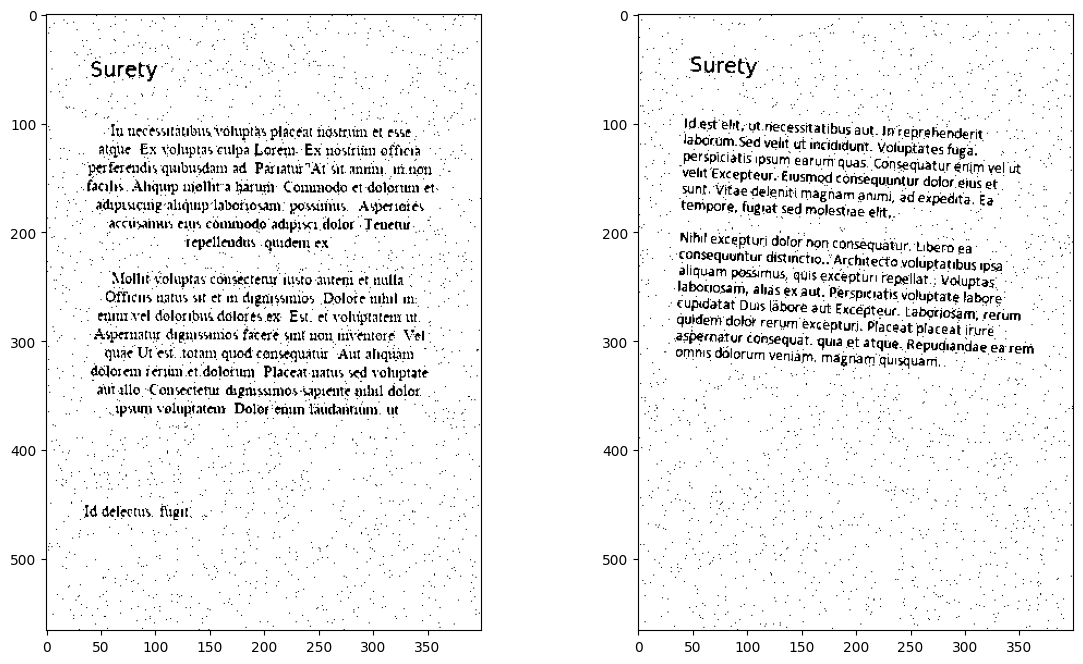

In [ ]:
# Load and open images
names = [ file for file in os.listdir(image_paths) ]
names = sorted(names)
N = len(names)

print(names[:10])

# Load two images to check
images = [Image.open(image_paths +'/'+names[i]) for i in range(2)]

plt.figure(figsize=(14,8))
plt.subplot(1,2,1),plt.imshow(images[0], cmap = 'gray')
plt.subplot(1,2,2),plt.imshow(images[1], cmap = 'gray')

print('Total number of images: %d'%N)

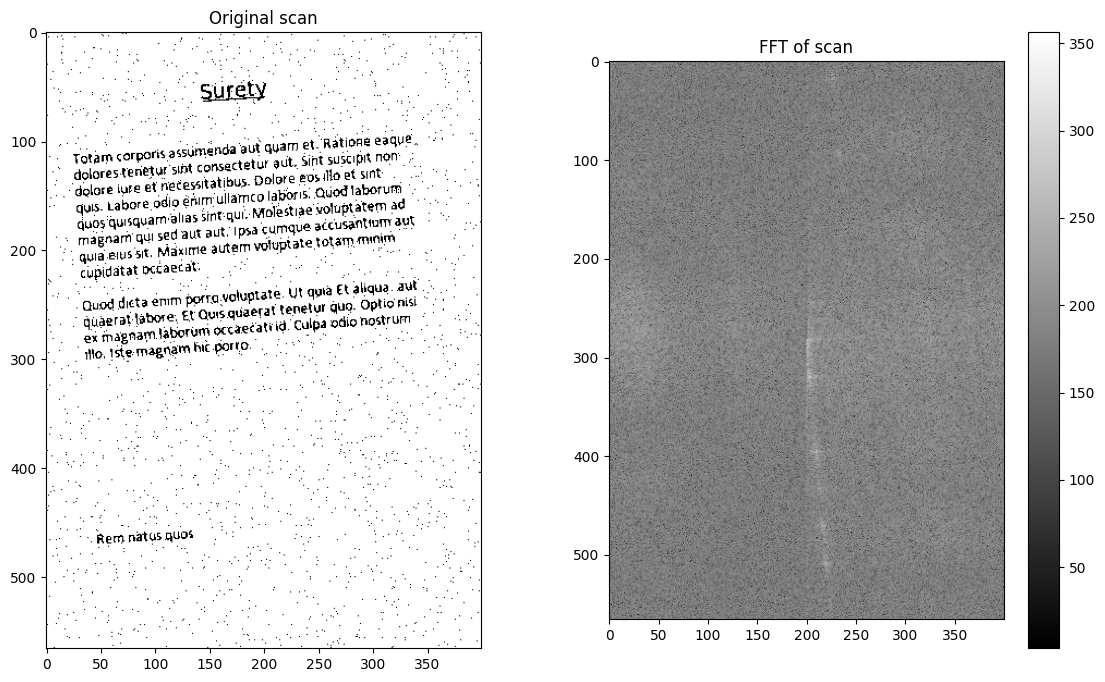

In [ ]:
eg_img = image_paths +'/'+names[18]
img = cv2.imread(eg_img)
img = img[:,:,0] #zeroth component is the red from RGB channel ordering
f = cv2.dft(np.float32(img))
fshift = np.fft.fftshift(f)
f_abs = np.abs(fshift) + 1.0 #shift to ensure no zeroes are present in image array
f_img = 20 * np.log(f_abs)

plt.figure(figsize=(14,8))

plt.subplot(1,2,1),plt.imshow(img, 'gray')
plt.title('Original scan')

plt.subplot(1,2,2),plt.imshow(f_img, 'gray')
plt.title('FFT of scan')
plt.colorbar()
plt.show()

<ipython-input-6-0a8df2eee31e>:1: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img = denoise_tv_chambolle(img, weight=1.0, multichannel=0)


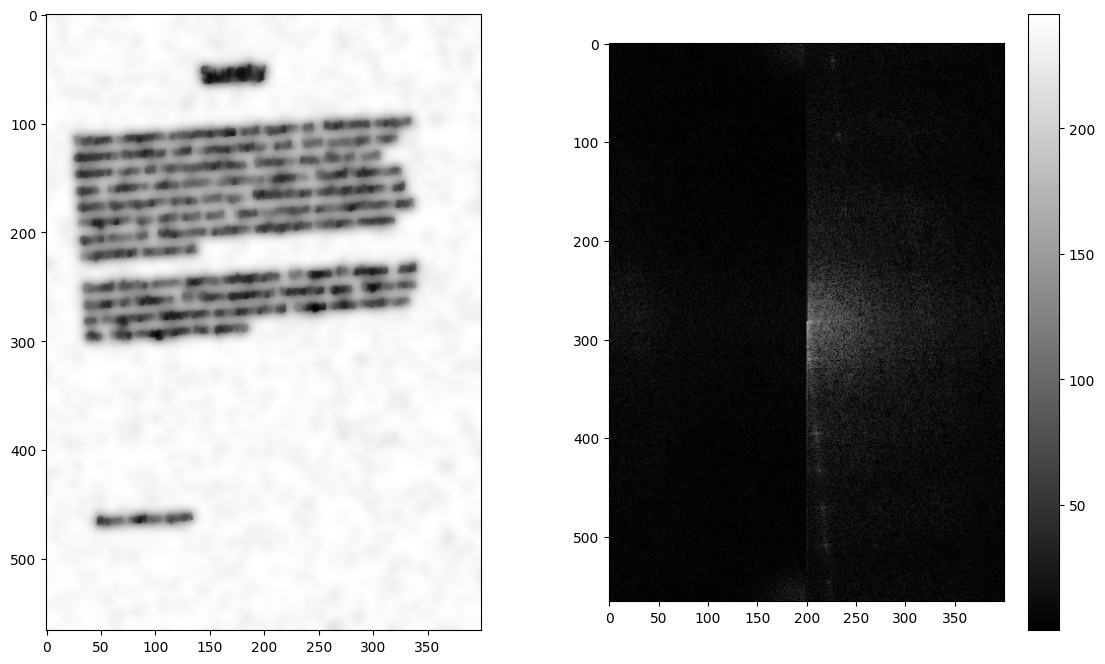

In [ ]:
img = denoise_tv_chambolle(img, weight=1.0, multichannel=0)

f = cv2.dft(np.float32(img))
fshift = np.fft.fftshift(f)
f_abs = np.abs(fshift) + 1.0
f_img = 20 * np.log(f_abs)

plt.figure(figsize=(14,8))
plt.subplot(121),plt.imshow(img, 'gray')
plt.subplot(122),plt.imshow(f_img, 'gray')
#os.system('mkdir -p ./processed')
#cv2.imwrite(path+'/processed/'+names[18], f_img)
plt.colorbar()
plt.show()

['scan_000.png', 'scan_001.png', 'scan_002.png', 'scan_003.png', 'scan_004.png', 'scan_005.png', 'scan_006.png', 'scan_007.png', 'scan_008.png', 'scan_009.png']


<ipython-input-4-e22f30701ec0>:13: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  tilted_img = denoise_tv_chambolle(tilted_img, weight=1.0, multichannel=0)


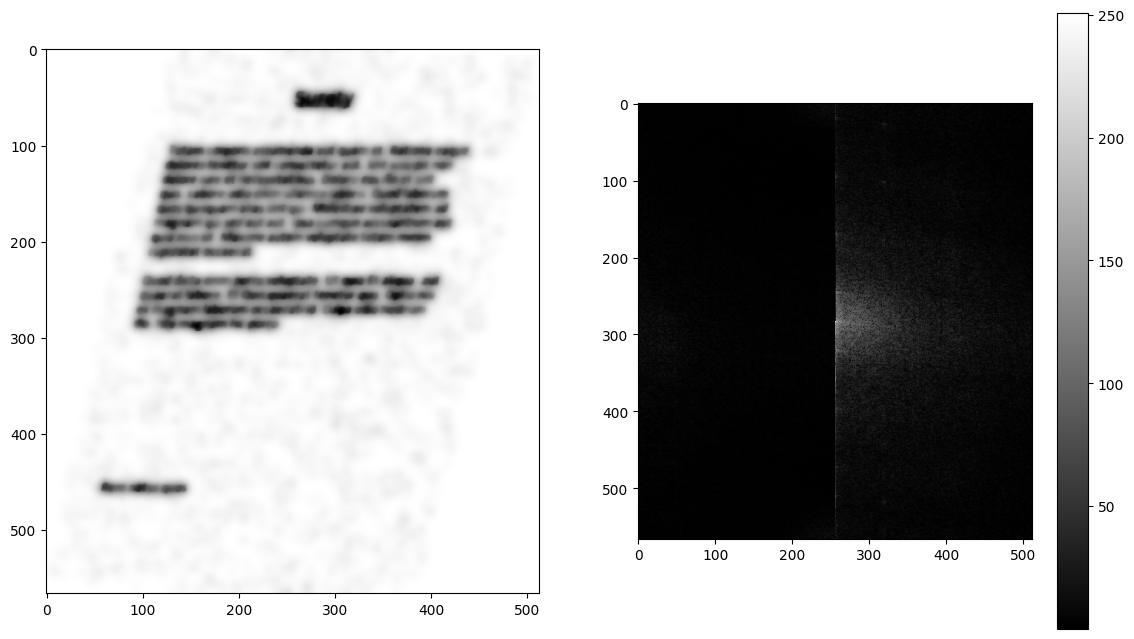

In [ ]:
# Load Tilted Images without Table
# Load and open images
tilted_names = [ file for file in os.listdir(tilted_image_paths) if file.endswith('.png')]
tilted_names = sorted(tilted_names)
tilted_N = len(tilted_names)

print(tilted_names[:10])

tilted_img_path = tilted_image_paths +'/'+tilted_names[18]
tilted_img = cv2.imread(tilted_img_path)
tilted_img = tilted_img[:,:,0] #zeroth component is the red from RGB channel ordering

tilted_img = denoise_tv_chambolle(tilted_img, weight=1.0, multichannel=0)

f = cv2.dft(np.float32(tilted_img))
fshift = np.fft.fftshift(f)
f_abs = np.abs(fshift) + 1.0
f_img = 20 * np.log(f_abs)


plt.figure(figsize=(14,8))
plt.subplot(121),plt.imshow(tilted_img, 'gray')
plt.subplot(122),plt.imshow(f_img, 'gray')

plt.colorbar()
plt.show()

['scan_000.png', 'scan_001.png', 'scan_002.png', 'scan_003.png', 'scan_004.png', 'scan_005.png', 'scan_006.png', 'scan_007.png', 'scan_008.png', 'scan_009.png']


<ipython-input-4-88838980dfad>:13: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  tilted_T_img = denoise_tv_chambolle(tilted_T_img, weight=1.0, multichannel=0)


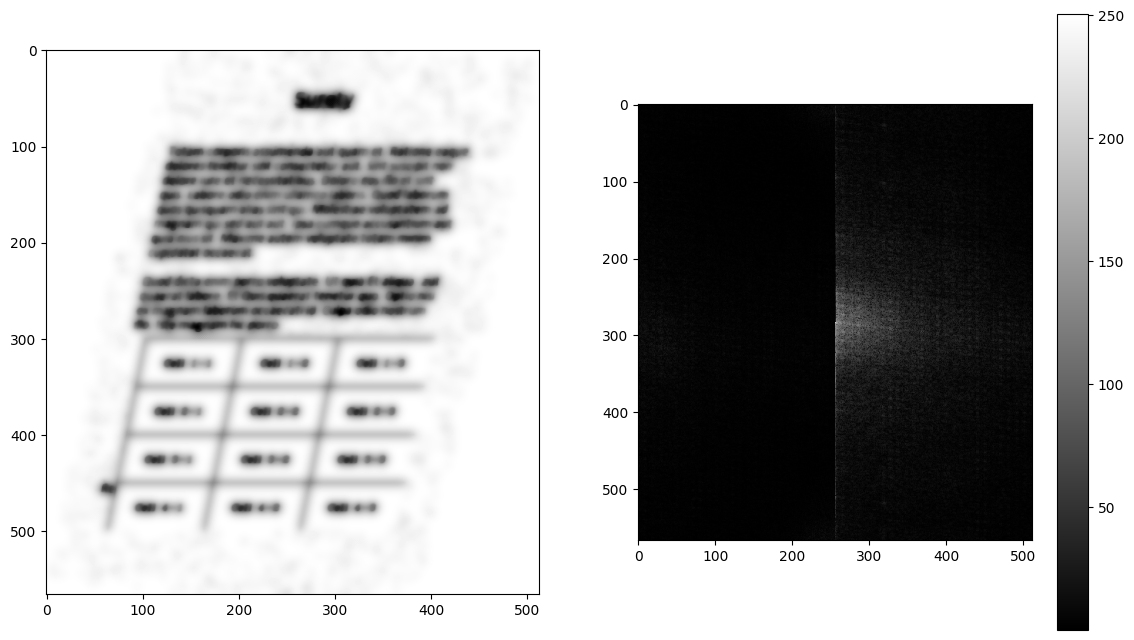

In [ ]:
# Load Tilted Images without Table
# Load and open images
tilted_T_names = [ file for file in os.listdir(tilted_T_image_paths) if file.endswith('.png') ]
tilted_T_names = sorted(tilted_T_names)
tilted_T_N = len(tilted_T_names)

print(tilted_T_names[:10])

tilted_T_img_path = tilted_T_image_paths +'/'+tilted_T_names[18]
tilted_T_img = cv2.imread(tilted_T_img_path)
tilted_T_img = tilted_T_img[:,:,0] #zeroth component is the red from RGB channel ordering

tilted_T_img = denoise_tv_chambolle(tilted_T_img, weight=1.0, multichannel=0)

f = cv2.dft(np.float32(tilted_T_img))
fshift = np.fft.fftshift(f)
f_abs = np.abs(fshift) + 1.0
f_img = 20 * np.log(f_abs)


plt.figure(figsize=(14,8))
plt.subplot(121),plt.imshow(tilted_T_img, 'gray')
plt.subplot(122),plt.imshow(f_img, 'gray')

plt.colorbar()
plt.show()

In [ ]:
# Load and open labels
label_names = [ file for file in os.listdir(label_paths) ]
label_names = sorted(label_names)
M = len(label_names)

print(label_names[:10])

labels = [ np.loadtxt(label_paths+ '/'+label_names[j])
for j in range(M) ]
labels = [ round(float(labels[j])) for j in range(M) ]

# Load first 10 labels
[print(labels[i]) for i in range(10)]
print('Total number of labels %d'%len(labels))

['scan_000.txt', 'scan_001.txt', 'scan_002.txt', 'scan_003.txt', 'scan_004.txt', 'scan_005.txt', 'scan_006.txt', 'scan_007.txt', 'scan_008.txt', 'scan_009.txt']
0
-2
-5
-5
-1
-1
4
0
-5
-2
Total number of labels 500


In [ ]:
# Load CSV file data into dataframe
def load_csv(location):
  csv_file_path = os.path.join(location, csv_file_name)

  # Read the CSV file into a DataFrame
  df = pd.read_csv(csv_file_path)

  return df


In [ ]:
# Load CSV file data into dataframe from the tilted images database
tilted_input_data = load_csv(tilted_image_paths)
tilted_input_data.head(5)

,FILE_NAME,TYPE,VALUE
0,scan_000.png,T,-0.2
1,scan_001.png,T,-0.2
2,scan_002.png,T,0.0
3,scan_003.png,T,-0.1
4,scan_004.png,T,-0.1


In [ ]:
# Load CSV file data into dataframe from the tilted images database
tilted_T_input_data = load_csv(tilted_T_image_paths)
tilted_T_input_data.head(5)

,FILE_NAME,TYPE,VALUE
0,scan_000.png,T,-0.2
1,scan_001.png,T,-0.2
2,scan_002.png,T,0.0
3,scan_003.png,T,-0.1
4,scan_004.png,T,-0.1


In [ ]:
# Deserialize JSON data lists for training and test sets
with open(root+'/train_list.json') as train_data:
    train = json.load(train_data)

train_size = len(train)
print('Training set size: %d'%train_size)

#with open(root+'/test_list.json') as test_data:
#    test = json.load(test_data)

#test_size = len(test)
#print('Test set size: %d'%test_size)

Training set size: 500


In [ ]:
# Load Skewed Dataset
fft_images = []
for i in range(train_size):
    img = cv2.imread(image_paths +'/'+names[i])
    img = img[:,:,0]
    img = denoise_tv_chambolle(img, weight=1.0, multichannel=0)
    f = cv2.dft(np.float32(img))
    fshift = np.fft.fftshift(f)
    f_abs = np.abs(fshift) + 1.0 # shift to avoid np.log(0) = nan
    f_img = 20 * np.log(f_abs)
    fft_images.append( f_img )
    #cv2.imwrite(path+'/processed/'+names[i], f_img)

<ipython-input-10-86b7284bb07a>:6: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img = denoise_tv_chambolle(img, weight=1.0, multichannel=0)


In [ ]:
# Load Tilted Dataset
fft_tilted_images = []
for i in range(train_size):
    img = cv2.imread(tilted_image_paths +'/'+ tilted_input_data.iloc[i][0])
    img = cv2.resize(img,(400,566))
    img = img[:,:,0]
    img = denoise_tv_chambolle(img, weight=1.0, multichannel=0)
    f = cv2.dft(np.float32(img))
    fshift = np.fft.fftshift(f)
    f_abs = np.abs(fshift) + 1.0 # shift to avoid np.log(0) = nan
    f_img = 20 * np.log(f_abs)
    fft_tilted_images.append( f_img )
    #cv2.imwrite(path+'/processed/'+names[i], f_img)

<ipython-input-8-21228afeee42>:7: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img = denoise_tv_chambolle(img, weight=1.0, multichannel=0)


In [ ]:
# Load Tilted with Table Dataset
fft_tilted_T_images = []
for i in range(train_size):
    img = cv2.imread(tilted_T_image_paths +'/'+tilted_T_input_data.iloc[i][0])
    img = cv2.resize(img,(400,566))
    img = img[:,:,0]
    img = denoise_tv_chambolle(img, weight=1.0, multichannel=0)
    f = cv2.dft(np.float32(img))
    fshift = np.fft.fftshift(f)
    f_abs = np.abs(fshift) + 1.0 # shift to avoid np.log(0) = nan
    f_img = 20 * np.log(f_abs)
    fft_tilted_T_images.append( f_img )
    #cv2.imwrite(path+'/processed/'+names[i], f_img)

<ipython-input-8-b1afe8cf9298>:7: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img = denoise_tv_chambolle(img, weight=1.0, multichannel=0)


In [ ]:
# Get images into tensor form
image_arr = [ tf.keras.preprocessing.image.img_to_array(fft_images[i]) for i in range(train_size) ]

# get pixel dimensions of image
img_height = image_arr[0].shape[0]
img_width = image_arr[0].shape[1]

print(f'image height: {img_height} width: {img_width}')

# Training and test image stacks
X = tf.stack(image_arr, axis=0, name='train_set')

X_images = np.array(X)
X_images /= 255

pixel_count = img_height * img_width

# Reshape to 3D Tensor
X = np.array(X).reshape(train_size, pixel_count)

# Normalise pixel values
X /= 255

# Training labels
Y_train_ = np.array(labels).reshape(len(labels))


# Check shape of each tensor
print(X.shape, Y_train_.shape)

image height: 566 width: 400
(500, 226400) (500,)


In [ ]:
# Get images into tensor form
tilted_image_arr = [ tf.keras.preprocessing.image.img_to_array(fft_tilted_images[i]) for i in range(train_size) ]

# get pixel dimensions of image
img_height = tilted_image_arr[0].shape[0]
img_width = tilted_image_arr[0].shape[1]

print(f'image height: {img_height} width: {img_width}')

# Training and test image stacks
tilted_X = tf.stack(tilted_image_arr, axis=0, name='train_set')

tilted_X_images = np.array(tilted_X)
tilted_X_images /= 255

pixel_count = img_height * img_width

# Reshape to 3D Tensor
tilted_X = np.array(tilted_X).reshape(train_size, pixel_count)

# Normalise pixel values
tilted_X /= 255

# Training labels
tilted_Y_train_ = np.array(tilted_input_data.VALUE * 10).reshape(len(tilted_input_data))


# Check shape of each tensor
print(tilted_X.shape, tilted_Y_train_.shape)

image height: 566 width: 400
(500, 226400) (500,)


In [ ]:
# Get images into tensor form
tilted_T_image_arr = [ tf.keras.preprocessing.image.img_to_array(fft_tilted_T_images[i]) for i in range(train_size) ]

# get pixel dimensions of image
img_height = tilted_T_image_arr[0].shape[0]
img_width = tilted_T_image_arr[0].shape[1]

print(f'image height: {img_height} width: {img_width}')

# Training and test image stacks
tilted_T_X = tf.stack(tilted_T_image_arr, axis=0, name='train_set')

tilted_T_X_images = np.array(tilted_T_X)
tilted_T_X_images /= 255

pixel_count = img_height * img_width

# Reshape to 3D Tensor
tilted_T_X = np.array(tilted_T_X).reshape(train_size, pixel_count)

# Normalise pixel values
tilted_T_X /= 255

# Training labels
tilted_T_Y_train_ = np.array(tilted_T_input_data.VALUE * 10).reshape(len(tilted_T_input_data))


# Check shape of each tensor
print(tilted_T_X.shape, tilted_T_Y_train_.shape)

image height: 566 width: 400
(500, 226400) (500,)


In [ ]:
# Show number of unique labels
classes = np.unique(Y_train_)
print(classes)
n_classes = len(np.unique(Y_train_))

# Create classes from unique labels
Y = to_categorical(Y_train_, n_classes)
print(Y.shape)

[-5 -4 -3 -2 -1  0  1  2  3  4  5]
(500, 11)


In [ ]:
Y_train_[:50]

array([ 0, -2, -5, -5, -1, -1,  4,  0, -5, -2, -3,  2, -1,  1, -1,  4, -4,
        3,  4, -1,  1, -4,  0,  4, -3,  2,  4,  2, -2,  0, -4,  4,  0, -5,
        4,  1,  0,  0, -2, -2, -5,  4, -1,  2,  0, -2, -3,  0,  2,  3])

In [ ]:
Y[:50]

array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0., 0., 0., 0., 0.

In [ ]:
# Show number of unique labels
tilted_classes = np.unique(tilted_Y_train_)
print(tilted_classes)
n_tilted_classes = len(np.unique(tilted_Y_train_))
n_classes = n_tilted_classes

# Create classes from unique labels
tilted_Y = to_categorical(tilted_Y_train_, n_tilted_classes)
print(tilted_Y.shape)

[-2. -1.  0.  1.  2.]
(500, 5)


In [ ]:
tilted_Y_train_[:11]

array([-2., -2.,  0., -1., -1., -1., -2.,  2., -2.,  2.,  1.])

In [ ]:
tilted_Y[:11]

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [ ]:
# Show number of unique labels
tilted_T_classes = np.unique(tilted_T_Y_train_)
print(tilted_T_classes)
n_tilted_T_classes = len(np.unique(tilted_T_Y_train_))
n_classes = n_tilted_T_classes

# Create classes from unique labels
tilted_T_Y = to_categorical(tilted_T_Y_train_, n_tilted_T_classes)
print(tilted_T_Y.shape)

[-2. -1.  0.  1.  2.]
(500, 5)


In [ ]:
tilted_T_Y_train_[:11]

array([-2., -2.,  0., -1., -1., -1., -2.,  2., -2.,  2.,  1.])

In [ ]:
tilted_T_Y[:11]

array([[0., 0., 0., 1., 0.],
       [0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 1.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.]], dtype=float32)

In [ ]:
# Craete Train, Val and Test dataset with 60%, 20% and 20% of labeled data
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.4, random_state=42)
X_val, X_test,  Y_val, Y_test = train_test_split(X_val, Y_val, test_size=0.5, random_state=42)

print(f'Train Dataset X: {X_train.shape} and Y: {Y_train.shape}')
print(f'Validation Dataset X: {X_val.shape} and Y: {Y_val.shape}')
print(f'Test Dataset X: {X_test.shape} and Y: {Y_test.shape}')

Train Dataset X: (300, 226400) and Y: (300, 11)
Validation Dataset X: (100, 226400) and Y: (100, 11)
Test Dataset X: (100, 226400) and Y: (100, 11)


In [ ]:
# Craete Train, Val and Test dataset with 60%, 20% and 20% of labeled data
X_tilted_train, X_tilted_val, Y_tilted_train, Y_tilted_val = train_test_split(tilted_X, tilted_Y, test_size=0.4, random_state=42)
X_tilted_val, X_tilted_test,  Y_tilted_val, Y_tilted_test = train_test_split(X_tilted_val, Y_tilted_val, test_size=0.5, random_state=42)

print(f'Train Dataset X: {X_tilted_train.shape} and Y: {Y_tilted_train.shape}')
print(f'Validation Dataset X: {X_tilted_val.shape} and Y: {Y_tilted_val.shape}')
print(f'Test Dataset X: {X_tilted_test.shape} and Y: {Y_tilted_test.shape}')

Train Dataset X: (300, 226400) and Y: (300, 5)
Validation Dataset X: (100, 226400) and Y: (100, 5)
Test Dataset X: (100, 226400) and Y: (100, 5)


In [ ]:
# Craete Train, Val and Test dataset with 60%, 20% and 20% of labeled data
X_tilted_T_train, X_tilted_T_val, Y_tilted_T_train, Y_tilted_T_val = train_test_split(tilted_T_X, tilted_T_Y, test_size=0.4, random_state=42)
X_tilted_T_val, X_tilted_T_test,  Y_tilted_T_val, Y_tilted_T_test = train_test_split(X_tilted_T_val, Y_tilted_T_val, test_size=0.5, random_state=42)

print(f'Train Dataset X: {X_tilted_T_train.shape} and Y: {Y_tilted_T_train.shape}')
print(f'Validation Dataset X: {X_tilted_T_val.shape} and Y: {Y_tilted_T_val.shape}')
print(f'Test Dataset X: {X_tilted_T_test.shape} and Y: {Y_tilted_T_test.shape}')

Train Dataset X: (300, 226400) and Y: (300, 5)
Validation Dataset X: (100, 226400) and Y: (100, 5)
Test Dataset X: (100, 226400) and Y: (100, 5)


In [ ]:
# Craete Train, Val and Test dataset with 60%, 20% and 20% of labeled data
X_train_img, X_val_img, Y_train_img, Y_val_img = train_test_split(X_images, Y, test_size=0.4, random_state=42)
X_val_img, X_test_img,  Y_val_img, Y_test_img = train_test_split(X_val_img, Y_val_img, test_size=0.5, random_state=42)

print(f'Train Dataset X: {X_train_img.shape} and Y: {Y_train_img.shape}')
print(f'Validation Dataset X: {X_val_img.shape} and Y: {Y_val_img.shape}')
print(f'Test Dataset X: {X_test_img.shape} and Y: {Y_test_img.shape}')

Train Dataset X: (300, 566, 400, 1) and Y: (300, 11)
Validation Dataset X: (100, 566, 400, 1) and Y: (100, 11)
Test Dataset X: (100, 566, 400, 1) and Y: (100, 11)


In [ ]:
# Craete Train, Val and Test dataset with 60%, 20% and 20% of labeled data
X_tilted_train_img, X_tilted_val_img, Y_tilted_train_img, Y_tilted_val_img = train_test_split(tilted_X_images, tilted_Y, test_size=0.4, random_state=42)
X_tilted_val_img, X_tilted_test_img,  Y_tilted_val_img, Y_tilted_test_img = train_test_split(X_tilted_val_img, Y_tilted_val_img, test_size=0.5, random_state=42)

print(f'Train Dataset X: {X_tilted_train_img.shape} and Y: {Y_tilted_train_img.shape}')
print(f'Validation Dataset X: {X_tilted_val_img.shape} and Y: {Y_tilted_val_img.shape}')
print(f'Test Dataset X: {X_tilted_test_img.shape} and Y: {Y_tilted_test_img.shape}')

Train Dataset X: (300, 566, 400, 1) and Y: (300, 5)
Validation Dataset X: (100, 566, 400, 1) and Y: (100, 5)
Test Dataset X: (100, 566, 400, 1) and Y: (100, 5)


In [ ]:
# Craete Train, Val and Test dataset with 60%, 20% and 20% of labeled data
X_tilted_T_train_img, X_tilted_T_val_img, Y_tilted_T_train_img, Y_tilted_T_val_img = train_test_split(tilted_T_X_images, tilted_T_Y, test_size=0.4, random_state=42)
X_tilted_T_val_img, X_tilted_T_test_img,  Y_tilted_T_val_img, Y_tilted_T_test_img = train_test_split(X_tilted_T_val_img, Y_tilted_T_val_img, test_size=0.5, random_state=42)

print(f'Train Dataset X: {X_tilted_T_train_img.shape} and Y: {Y_tilted_T_train_img.shape}')
print(f'Validation Dataset X: {X_tilted_T_val_img.shape} and Y: {Y_tilted_T_val_img.shape}')
print(f'Test Dataset X: {X_tilted_T_test_img.shape} and Y: {Y_tilted_T_test_img.shape}')

Train Dataset X: (300, 566, 400, 1) and Y: (300, 5)
Validation Dataset X: (100, 566, 400, 1) and Y: (100, 5)
Test Dataset X: (100, 566, 400, 1) and Y: (100, 5)


## MLP Implementation

In [ ]:
# Model with Multilayer Perceptron (MLP)

mlp_model = Sequential()

mlp_model.add(Dense(512, activation='relu',
                 input_shape=(pixel_count,)))

mlp_model.add(Dense(512, activation='relu'))

mlp_model.add(Dense(512, activation='relu'))

mlp_model.add(Dense(512, activation='relu'))
mlp_model.add(Dropout(0.2))

mlp_model.add(Dense(512, activation='relu'))
mlp_model.add(Dropout(0.2))

mlp_model.add(Dense(n_classes, activation = 'softmax'))

In [ ]:
mlp_model.compile(optimizer = 'adam',
             loss = 'categorical_crossentropy',
             metrics = ['accuracy'] )

In [ ]:
mlp_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               115917312 
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0

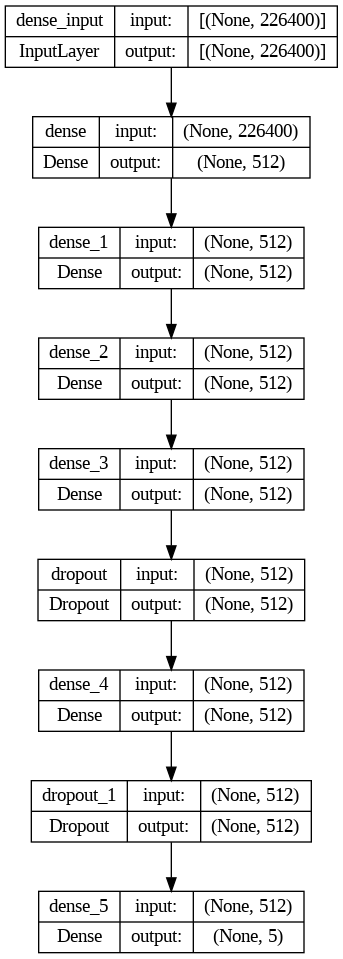

In [ ]:
from keras.utils import plot_model

plot_model(mlp_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
#history = model.fit(X_train, Y_train, batch_size=32, epochs=25, verbose=2)
# Train the model and keep track of history
mlp_history = mlp_model.fit(X_train, Y_train, batch_size=32, epochs=30, verbose=2, validation_data=(X_val, Y_val))

Epoch 1/30
10/10 - 1s - loss: 0.2207 - accuracy: 0.9133 - val_loss: 4.6171 - val_accuracy: 0.2600 - 658ms/epoch - 66ms/step
Epoch 2/30
10/10 - 0s - loss: 1.6021 - accuracy: 0.6167 - val_loss: 1.9254 - val_accuracy: 0.2900 - 408ms/epoch - 41ms/step
Epoch 3/30
10/10 - 0s - loss: 0.6996 - accuracy: 0.7667 - val_loss: 1.7308 - val_accuracy: 0.2000 - 411ms/epoch - 41ms/step
Epoch 4/30
10/10 - 0s - loss: 0.2551 - accuracy: 0.9367 - val_loss: 2.1195 - val_accuracy: 0.2900 - 425ms/epoch - 42ms/step
Epoch 5/30
10/10 - 0s - loss: 0.0647 - accuracy: 0.9867 - val_loss: 0.9894 - val_accuracy: 0.6100 - 435ms/epoch - 43ms/step
Epoch 6/30
10/10 - 0s - loss: 0.0088 - accuracy: 1.0000 - val_loss: 1.1865 - val_accuracy: 0.5300 - 414ms/epoch - 41ms/step
Epoch 7/30
10/10 - 0s - loss: 0.0088 - accuracy: 0.9967 - val_loss: 1.6410 - val_accuracy: 0.5700 - 419ms/epoch - 42ms/step
Epoch 8/30
10/10 - 0s - loss: 0.0026 - accuracy: 1.0000 - val_loss: 1.7118 - val_accuracy: 0.5300 - 487ms/epoch - 49ms/step
Epoch 9/

In [ ]:
# Evaluate the model on the validation dataset
mlp_val_loss, mlp_val_accuracy = mlp_model.evaluate(X_test, Y_test)

4/4 [==============================] - 0s 14ms/step - loss: 1.1778 - accuracy: 0.5200


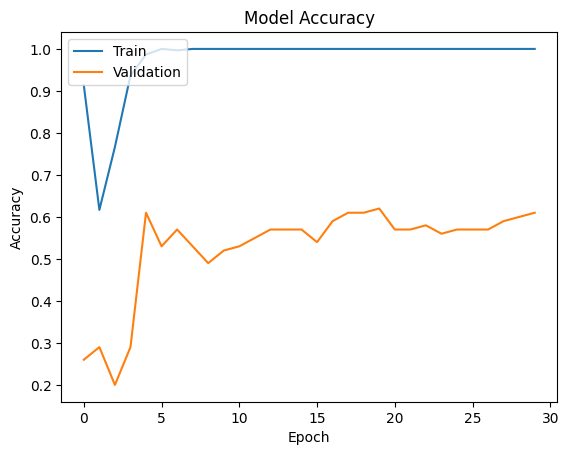

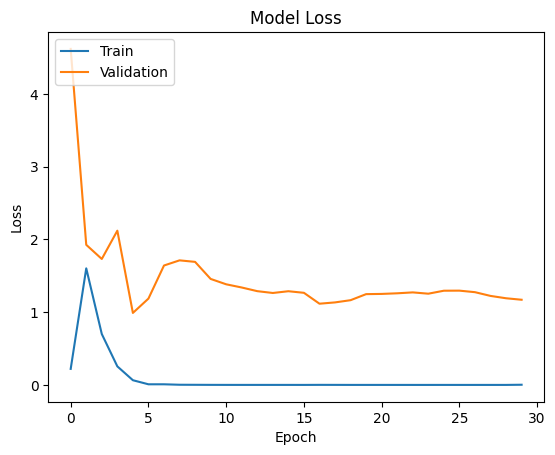

In [ ]:
# Plot training & validation accuracy values
plt.plot(mlp_history.history['accuracy'])
plt.plot(mlp_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(mlp_history.history['loss'])
plt.plot(mlp_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
mlp_predictions = mlp_model.predict(X_test)
# Apply argmax to the predictions to get the class labels
mlp_predicted_labels = np.argmax(mlp_predictions, axis=1)


mlp_fpr = dict()
mlp_tpr = dict()
mlp_roc_auc = dict()

for i in range(n_classes):
    mlp_fpr[i], mlp_tpr[i], _ = roc_curve(Y_test[:, i], mlp_predictions[:, i])
    mlp_roc_auc[i] = roc_auc_score(Y_test[:, i], mlp_predictions[:, i])

# Aggregate the results to get a sense of the overall performance
# This is typically done by averaging the ROC AUC values
mlp_mean_auc = np.mean(list(mlp_roc_auc.values()))

print(f'Mean AUC: {mlp_mean_auc}')

4/4 [==============================] - 0s 10ms/step
Mean AUC: 0.980725611601278


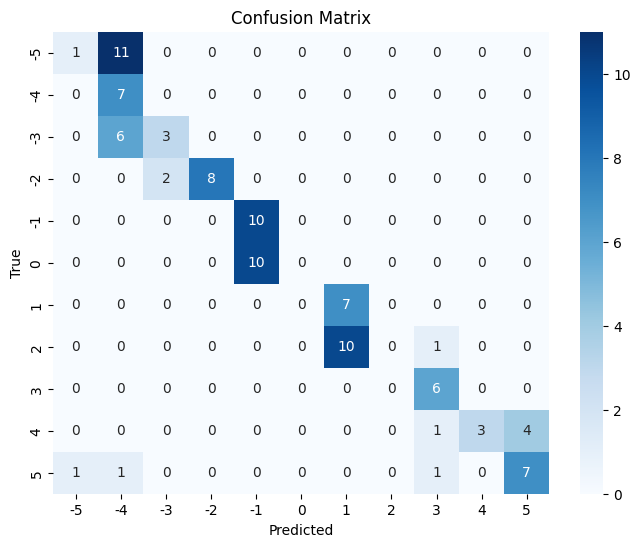

In [ ]:
# Create a confusion matrix
cm = confusion_matrix(classes[np.argmax(Y_test, axis=1)], classes[mlp_predicted_labels])

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5], yticklabels=[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

### Save the Model for future use

In [ ]:
mlp_model.save(f'{model_path}/{model_mlp}')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Tilted Dataset Training with MLP

In [ ]:
#history = model.fit(X_train, Y_train, batch_size=32, epochs=25, verbose=2)
# Train the model and keep track of history
mlp_tilted_history = mlp_model.fit(X_tilted_train, Y_tilted_train, batch_size=32, epochs=30, verbose=2, validation_data=(X_tilted_val, Y_tilted_val))

Epoch 1/30
10/10 - 11s - loss: 3.4738 - accuracy: 0.1900 - val_loss: 2.0458 - val_accuracy: 0.2800 - 11s/epoch - 1s/step
Epoch 2/30
10/10 - 1s - loss: 2.0117 - accuracy: 0.1967 - val_loss: 1.7301 - val_accuracy: 0.1600 - 594ms/epoch - 59ms/step
Epoch 3/30
10/10 - 1s - loss: 1.6961 - accuracy: 0.1867 - val_loss: 1.4836 - val_accuracy: 0.3200 - 616ms/epoch - 62ms/step
Epoch 4/30
10/10 - 1s - loss: 1.5278 - accuracy: 0.3167 - val_loss: 1.2803 - val_accuracy: 0.5100 - 602ms/epoch - 60ms/step
Epoch 5/30
10/10 - 1s - loss: 1.2350 - accuracy: 0.4567 - val_loss: 1.0044 - val_accuracy: 0.5500 - 566ms/epoch - 57ms/step
Epoch 6/30
10/10 - 0s - loss: 0.9919 - accuracy: 0.6033 - val_loss: 0.7063 - val_accuracy: 0.6700 - 423ms/epoch - 42ms/step
Epoch 7/30
10/10 - 0s - loss: 0.6551 - accuracy: 0.6967 - val_loss: 0.9330 - val_accuracy: 0.6000 - 495ms/epoch - 50ms/step
Epoch 8/30
10/10 - 0s - loss: 0.5778 - accuracy: 0.7700 - val_loss: 0.2973 - val_accuracy: 0.9700 - 425ms/epoch - 42ms/step
Epoch 9/30


In [ ]:
# Evaluate the model on the validation dataset
mlp_tilted_val_loss, mlp_tilted_val_accuracy = mlp_model.evaluate(X_tilted_test, Y_tilted_test)

4/4 [==============================] - 0s 15ms/step - loss: 0.0253 - accuracy: 0.9800


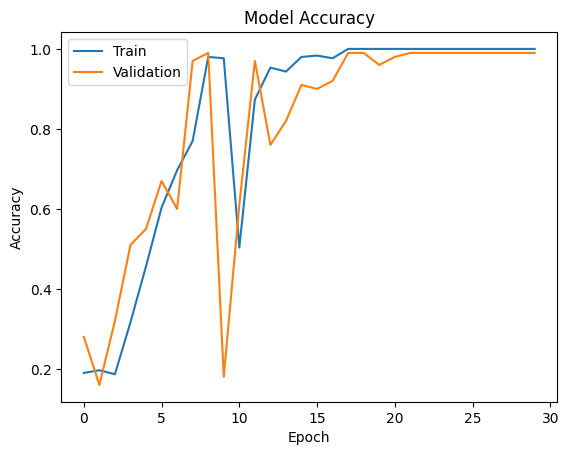

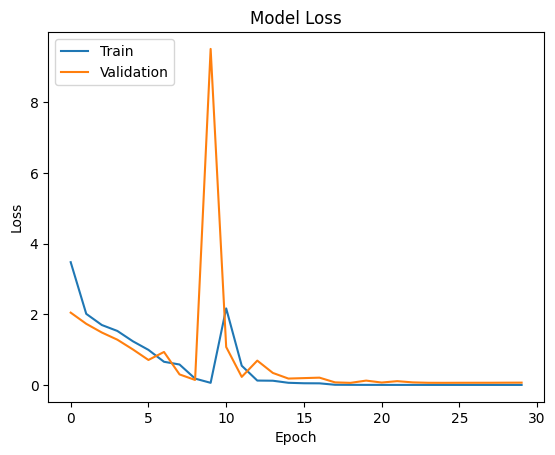

In [ ]:
# Plot training & validation accuracy values
plt.plot(mlp_tilted_history.history['accuracy'])
plt.plot(mlp_tilted_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(mlp_tilted_history.history['loss'])
plt.plot(mlp_tilted_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
mlp_tilted_predictions = mlp_model.predict(X_tilted_test)
# Apply argmax to the predictions to get the class labels
mlp_tilted_predicted_labels = np.argmax(mlp_tilted_predictions, axis=1)


mlp_fpr = dict()
mlp_tpr = dict()
mlp_roc_auc = dict()

for i in range(n_tilted_classes):
    mlp_fpr[i], mlp_tpr[i], _ = roc_curve(Y_tilted_test[:, i], mlp_tilted_predictions[:, i])
    mlp_roc_auc[i] = roc_auc_score(Y_tilted_test[:, i], mlp_tilted_predictions[:, i])

# Aggregate the results to get a sense of the overall performance
# This is typically done by averaging the ROC AUC values
mlp_tilted_mean_auc = np.mean(list(mlp_roc_auc.values()))

print(f'Mean AUC: {mlp_tilted_mean_auc}')

4/4 [==============================] - 0s 10ms/step
Mean AUC: 1.0


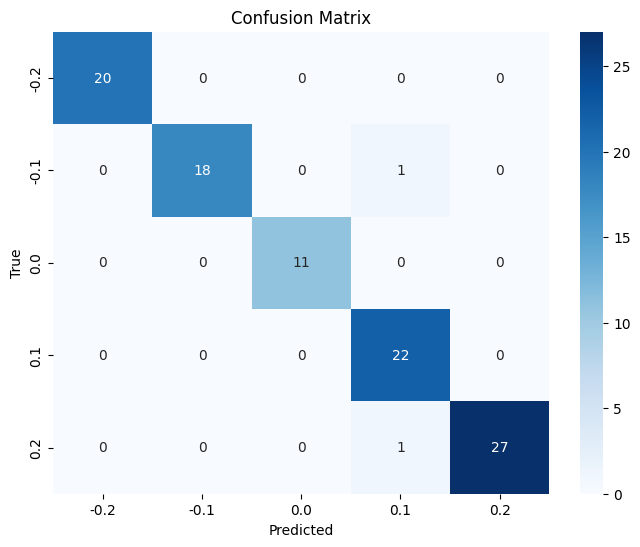

In [ ]:
# Create a confusion matrix
cm = confusion_matrix(tilted_classes[np.argmax(Y_tilted_test, axis=1)], tilted_classes[mlp_tilted_predicted_labels])

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[-0.2,-0.1,0.0,0.1,0.2], yticklabels=[-0.2,-0.1,0.0,0.1,0.2])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
mlp_model.save(f'{model_path}/{tilted_model_mlp}')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Tilted Dataset Training with Tables MLP

In [ ]:
#history = model.fit(X_train, Y_train, batch_size=32, epochs=25, verbose=2)
# Train the model and keep track of history
mlp_tilted_T_history = mlp_model.fit(X_tilted_T_train, Y_tilted_T_train, batch_size=32, epochs=30, verbose=2, validation_data=(X_tilted_T_val, Y_tilted_T_val))

Epoch 1/30
10/10 - 8s - loss: 2.7797 - accuracy: 0.2333 - val_loss: 1.8177 - val_accuracy: 0.1500 - 8s/epoch - 819ms/step
Epoch 2/30
10/10 - 0s - loss: 1.6020 - accuracy: 0.2767 - val_loss: 1.5550 - val_accuracy: 0.1800 - 464ms/epoch - 46ms/step
Epoch 3/30
10/10 - 0s - loss: 0.9815 - accuracy: 0.6300 - val_loss: 0.5764 - val_accuracy: 0.8000 - 450ms/epoch - 45ms/step
Epoch 4/30
10/10 - 0s - loss: 0.2496 - accuracy: 0.9067 - val_loss: 0.0663 - val_accuracy: 0.9900 - 442ms/epoch - 44ms/step
Epoch 5/30
10/10 - 1s - loss: 0.0220 - accuracy: 0.9967 - val_loss: 0.0021 - val_accuracy: 1.0000 - 514ms/epoch - 51ms/step
Epoch 6/30
10/10 - 0s - loss: 0.0012 - accuracy: 1.0000 - val_loss: 0.0017 - val_accuracy: 1.0000 - 499ms/epoch - 50ms/step
Epoch 7/30
10/10 - 0s - loss: 1.9046e-04 - accuracy: 1.0000 - val_loss: 0.0027 - val_accuracy: 1.0000 - 426ms/epoch - 43ms/step
Epoch 8/30
10/10 - 1s - loss: 5.7545e-05 - accuracy: 1.0000 - val_loss: 9.7730e-05 - val_accuracy: 1.0000 - 500ms/epoch - 50ms/ste

In [ ]:
# Evaluate the model on the validation dataset
mlp_tilted_T_val_loss, mlp_tilted_T_val_accuracy = mlp_model.evaluate(X_tilted_T_val, Y_tilted_T_val)

4/4 [==============================] - 0s 14ms/step - loss: 8.6855e-06 - accuracy: 1.0000


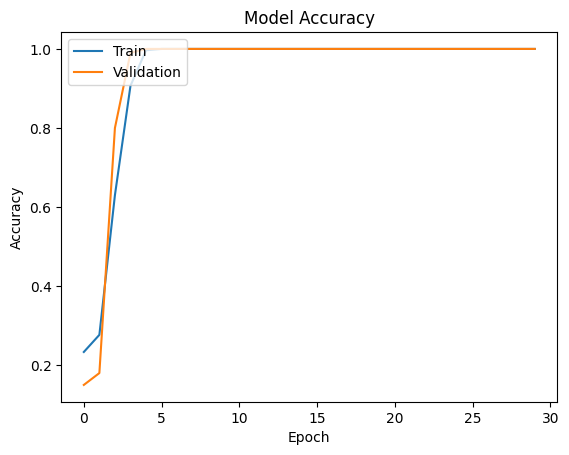

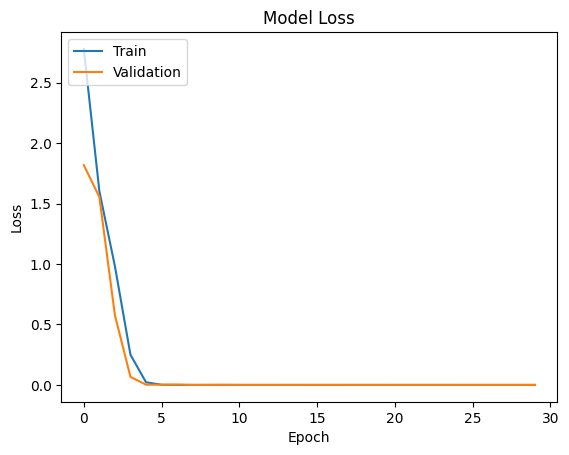

In [ ]:
# Plot training & validation accuracy values
plt.plot(mlp_tilted_T_history.history['accuracy'])
plt.plot(mlp_tilted_T_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(mlp_tilted_T_history.history['loss'])
plt.plot(mlp_tilted_T_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
mlp_tilted_T_predictions = mlp_model.predict(X_tilted_T_test)
# Apply argmax to the predictions to get the class labels
mlp_tilted_T_predicted_labels = np.argmax(mlp_tilted_T_predictions, axis=1)


mlp_fpr = dict()
mlp_tpr = dict()
mlp_roc_auc = dict()

for i in range(n_tilted_T_classes):
    mlp_fpr[i], mlp_tpr[i], _ = roc_curve(Y_tilted_T_test[:, i], mlp_tilted_T_predictions[:, i])
    mlp_roc_auc[i] = roc_auc_score(Y_tilted_T_test[:, i], mlp_tilted_T_predictions[:, i])

# Aggregate the results to get a sense of the overall performance
# This is typically done by averaging the ROC AUC values
mlp_tilted_T_mean_auc = np.mean(list(mlp_roc_auc.values()))

print(f'Mean AUC: {mlp_tilted_T_mean_auc}')

4/4 [==============================] - 0s 18ms/step
Mean AUC: 1.0


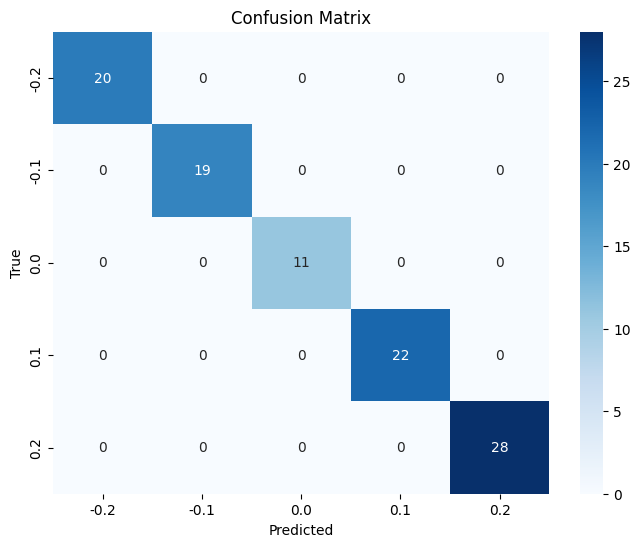

In [ ]:
# Create a confusion matrix
cm = confusion_matrix(tilted_T_classes[np.argmax(Y_tilted_T_test, axis=1)], tilted_T_classes[mlp_tilted_T_predicted_labels])

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[-0.2,-0.1,0.0,0.1,0.2], yticklabels=[-0.2,-0.1,0.0,0.1,0.2])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
mlp_model.save(f'{model_path}/{tilted_T_model_mlp}')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## CNN Model

In [ ]:
# Model with CNN

cnn_model = Sequential()

cnn_model.add(Conv2D(filters = 32, kernel_size = (3,3), padding = 'Same', activation = 'relu', input_shape = (566,400,1)))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))

cnn_model.add(Conv2D(filters = 64, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

cnn_model.add(Conv2D(filters = 96, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

cnn_model.add(Conv2D(filters = 96, kernel_size = (3,3), padding = 'Same', activation = 'relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2), strides=(2,2)))

cnn_model.add(Flatten())
cnn_model.add(Dense(512, activation='relu'))
cnn_model.add(Dense(n_classes, activation='softmax')) # 11 classes (-5 to 5)

In [ ]:
cnn_model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'] )
cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 566, 400, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 283, 200, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 283, 200, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 141, 100, 64)      0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 141, 100, 96)      55392     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 70, 50, 96)       

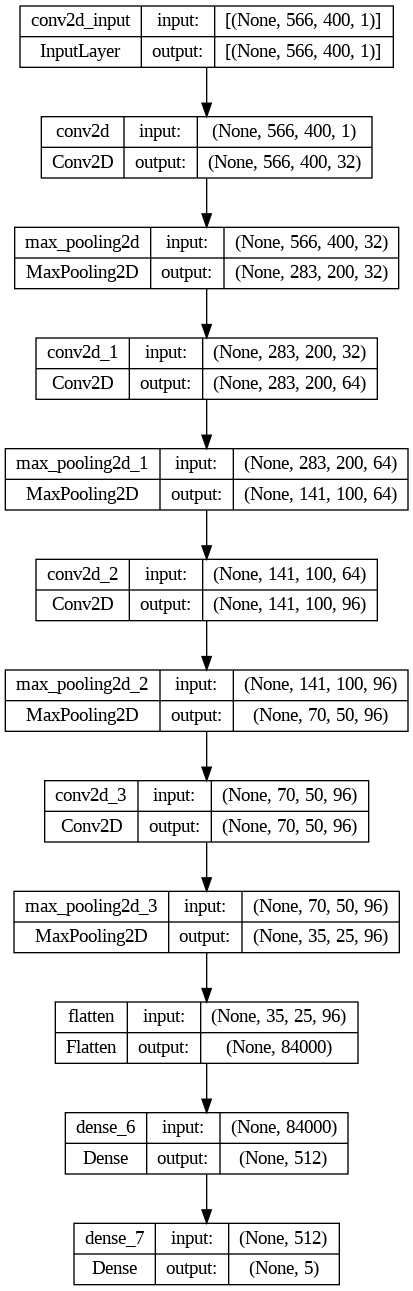

In [ ]:
from keras.utils import plot_model

plot_model(cnn_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
#history = model.fit(X_train, Y_train, batch_size=32, epochs=25, verbose=2)
# Train the model and keep track of history
cnn_history = cnn_model.fit(X_train_img, Y_train_img, batch_size=32, epochs=30, verbose=2, validation_data=(X_val_img, Y_val_img))

Epoch 1/30
10/10 - 16s - loss: 2.4239 - accuracy: 0.0700 - val_loss: 2.3915 - val_accuracy: 0.0700 - 16s/epoch - 2s/step
Epoch 2/30
10/10 - 2s - loss: 2.3972 - accuracy: 0.1133 - val_loss: 2.3852 - val_accuracy: 0.0900 - 2s/epoch - 189ms/step
Epoch 3/30
10/10 - 2s - loss: 2.3571 - accuracy: 0.1500 - val_loss: 2.3674 - val_accuracy: 0.1200 - 2s/epoch - 183ms/step
Epoch 4/30
10/10 - 2s - loss: 2.3203 - accuracy: 0.1967 - val_loss: 2.2828 - val_accuracy: 0.1900 - 2s/epoch - 184ms/step
Epoch 5/30
10/10 - 2s - loss: 2.0815 - accuracy: 0.3033 - val_loss: 1.9198 - val_accuracy: 0.1900 - 2s/epoch - 198ms/step
Epoch 6/30
10/10 - 2s - loss: 1.2707 - accuracy: 0.5600 - val_loss: 1.2845 - val_accuracy: 0.4500 - 2s/epoch - 183ms/step
Epoch 7/30
10/10 - 2s - loss: 0.6759 - accuracy: 0.7233 - val_loss: 0.5711 - val_accuracy: 0.7700 - 2s/epoch - 185ms/step
Epoch 8/30
10/10 - 2s - loss: 0.3074 - accuracy: 0.8667 - val_loss: 0.3463 - val_accuracy: 0.8400 - 2s/epoch - 190ms/step
Epoch 9/30
10/10 - 2s - l

In [ ]:
# Evaluate the model on the validation dataset
cnn_val_loss, cnn_val_accuracy = cnn_model.evaluate(X_test_img, Y_test_img)

4/4 [==============================] - 0s 56ms/step - loss: 0.0573 - accuracy: 0.9700


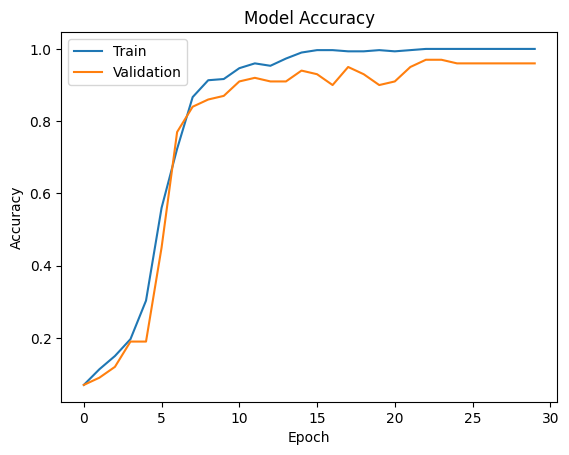

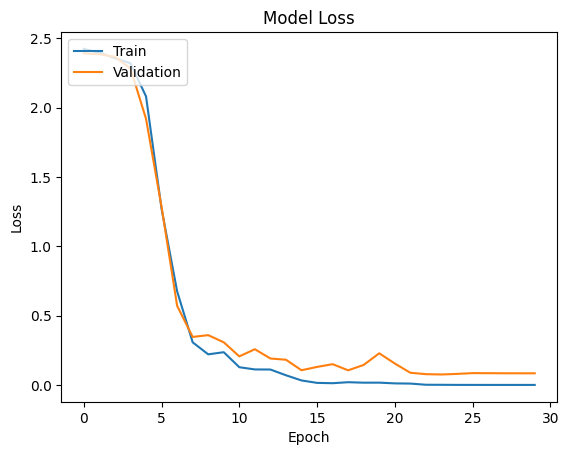

In [ ]:
# Plot training & validation accuracy values
plt.plot(cnn_history.history['accuracy'])
plt.plot(cnn_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(cnn_history.history['loss'])
plt.plot(cnn_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
cnn_predictions = cnn_model.predict(X_test_img)
# Apply argmax to the predictions to get the class labels
cnn_predicted_labels = np.argmax(cnn_predictions, axis=1)

4/4 [==============================] - 0s 70ms/step


In [ ]:
cnn_fpr = dict()
cnn_tpr = dict()
cnn_roc_auc = dict()

for i in range(n_classes):
    cnn_fpr[i], cnn_tpr[i], _ = roc_curve(Y_test_img[:, i], cnn_predictions[:, i])
    cnn_roc_auc[i] = roc_auc_score(Y_test_img[:, i], cnn_predictions[:, i])

# Aggregate the results to get a sense of the overall performance
# This is typically done by averaging the ROC AUC values
cnn_mean_auc = np.mean(list(cnn_roc_auc.values()))

print(f'Mean AUC: {cnn_mean_auc}')

Mean AUC: 0.9997754721124287


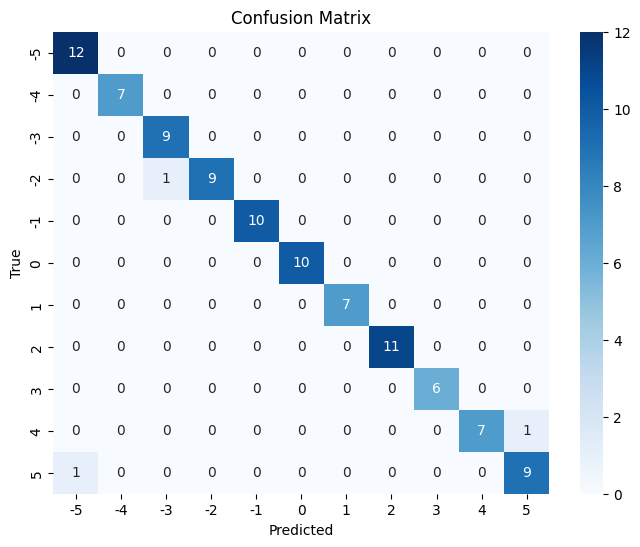

In [ ]:
# Create a confusion matrix
cm = confusion_matrix(classes[np.argmax(Y_test_img, axis=1)], classes[cnn_predicted_labels])

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5], yticklabels=[-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
cnn_model.save(f'{model_path}/{model_cnn}')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Tilted Dataset Training with CNN

In [ ]:
#history = model.fit(X_train, Y_train, batch_size=32, epochs=25, verbose=2)
# Train the model and keep track of history
tilted_cnn_history = cnn_model.fit(X_tilted_train_img, Y_tilted_train_img, batch_size=32, epochs=30, verbose=2, validation_data=(X_tilted_val_img, Y_tilted_val_img))

Epoch 1/30
10/10 - 16s - loss: 1.6027 - accuracy: 0.2300 - val_loss: 1.6414 - val_accuracy: 0.1600 - 16s/epoch - 2s/step
Epoch 2/30
10/10 - 2s - loss: 1.5936 - accuracy: 0.2500 - val_loss: 1.5611 - val_accuracy: 0.3900 - 2s/epoch - 208ms/step
Epoch 3/30
10/10 - 2s - loss: 1.4911 - accuracy: 0.3433 - val_loss: 1.3394 - val_accuracy: 0.5800 - 2s/epoch - 195ms/step
Epoch 4/30
10/10 - 2s - loss: 1.1636 - accuracy: 0.5367 - val_loss: 0.9011 - val_accuracy: 0.6200 - 2s/epoch - 193ms/step
Epoch 5/30
10/10 - 2s - loss: 0.8188 - accuracy: 0.6267 - val_loss: 0.6893 - val_accuracy: 0.6800 - 2s/epoch - 207ms/step
Epoch 6/30
10/10 - 2s - loss: 0.5343 - accuracy: 0.7767 - val_loss: 0.4236 - val_accuracy: 0.8800 - 2s/epoch - 201ms/step
Epoch 7/30
10/10 - 2s - loss: 0.2480 - accuracy: 0.9033 - val_loss: 0.2062 - val_accuracy: 0.9700 - 2s/epoch - 239ms/step
Epoch 8/30
10/10 - 2s - loss: 0.1040 - accuracy: 0.9767 - val_loss: 0.2057 - val_accuracy: 0.9900 - 2s/epoch - 219ms/step
Epoch 9/30
10/10 - 2s - l

In [ ]:
# Evaluate the model on the validation dataset
tilted_cnn_val_loss, tilted_cnn_val_accuracy = cnn_model.evaluate(X_tilted_test_img, Y_tilted_test_img)

4/4 [==============================] - 0s 55ms/step - loss: 0.0122 - accuracy: 0.9900


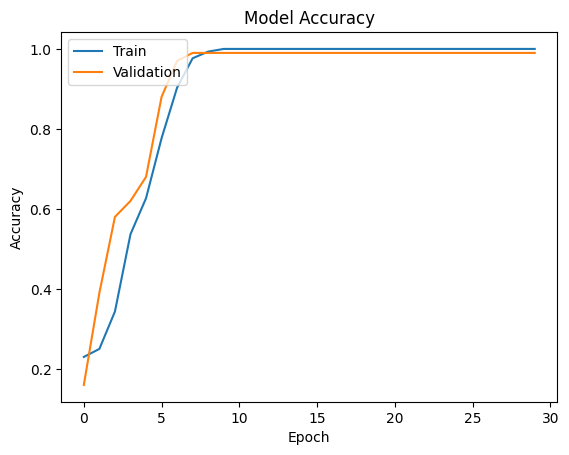

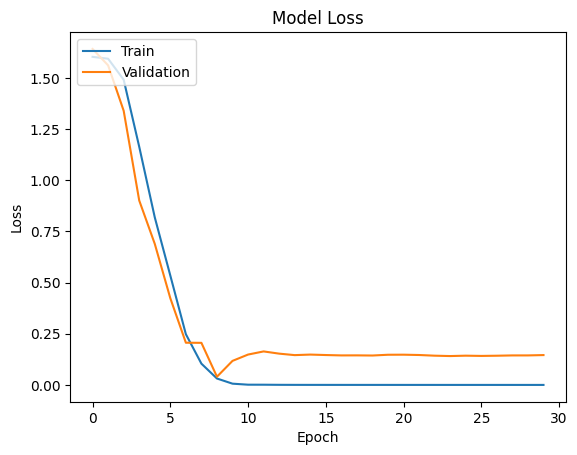

In [ ]:
# Plot training & validation accuracy values
plt.plot(tilted_cnn_history.history['accuracy'])
plt.plot(tilted_cnn_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(tilted_cnn_history.history['loss'])
plt.plot(tilted_cnn_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
tilted_cnn_predictions = cnn_model.predict(X_tilted_test_img)
# Apply argmax to the predictions to get the class labels
tilted_cnn_predicted_labels = np.argmax(tilted_cnn_predictions, axis=1)

4/4 [==============================] - 0s 67ms/step


In [ ]:
cnn_fpr = dict()
cnn_tpr = dict()
cnn_roc_auc = dict()

for i in range(n_classes):
    cnn_fpr[i], cnn_tpr[i], _ = roc_curve(Y_tilted_test_img[:, i], tilted_cnn_predictions[:, i])
    cnn_roc_auc[i] = roc_auc_score(Y_tilted_test_img[:, i], tilted_cnn_predictions[:, i])

# Aggregate the results to get a sense of the overall performance
# This is typically done by averaging the ROC AUC values
tilted_cnn_mean_auc = np.mean(list(cnn_roc_auc.values()))

print(f'Mean AUC: {tilted_cnn_mean_auc}')

Mean AUC: 1.0


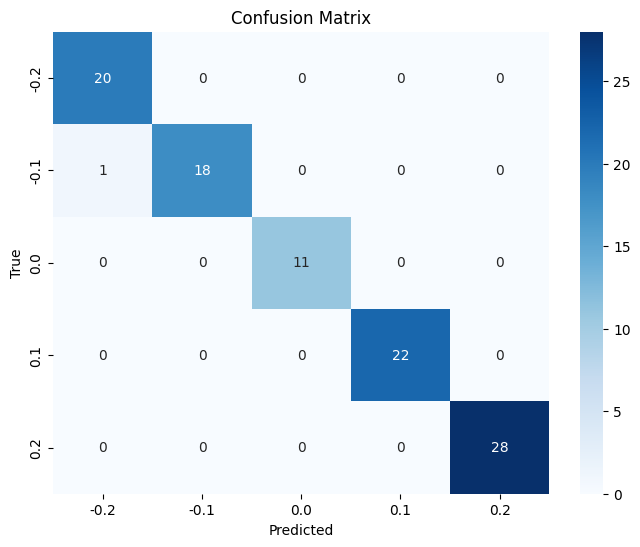

In [ ]:
# Create a confusion matrix
cm = confusion_matrix(tilted_classes[np.argmax(Y_tilted_test_img, axis=1)], tilted_classes[tilted_cnn_predicted_labels])

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[-0.2,-0.1,0.0,0.1,0.2], yticklabels=[-0.2,-0.1,0.0,0.1,0.2])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
cnn_model.save(f'{model_path}/{tilted_model_cnn}')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Tilted Dataset Training with Tables in CNN

In [ ]:
#history = model.fit(X_train, Y_train, batch_size=32, epochs=25, verbose=2)
# Train the model and keep track of history
tilted_T_cnn_history = cnn_model.fit(X_tilted_T_train_img, Y_tilted_T_train_img, batch_size=32, epochs=30, verbose=2, validation_data=(X_tilted_T_val_img, Y_tilted_T_val_img))

Epoch 1/30
10/10 - 16s - loss: 1.6207 - accuracy: 0.2200 - val_loss: 1.6000 - val_accuracy: 0.3800 - 16s/epoch - 2s/step
Epoch 2/30
10/10 - 2s - loss: 1.5960 - accuracy: 0.2167 - val_loss: 1.5479 - val_accuracy: 0.4800 - 2s/epoch - 196ms/step
Epoch 3/30
10/10 - 2s - loss: 1.5088 - accuracy: 0.3567 - val_loss: 1.3376 - val_accuracy: 0.3500 - 2s/epoch - 202ms/step
Epoch 4/30
10/10 - 2s - loss: 1.0782 - accuracy: 0.5033 - val_loss: 0.6556 - val_accuracy: 0.6500 - 2s/epoch - 204ms/step
Epoch 5/30
10/10 - 2s - loss: 0.5221 - accuracy: 0.8033 - val_loss: 0.2429 - val_accuracy: 0.9800 - 2s/epoch - 193ms/step
Epoch 6/30
10/10 - 2s - loss: 0.7377 - accuracy: 0.8267 - val_loss: 0.2387 - val_accuracy: 0.9900 - 2s/epoch - 204ms/step
Epoch 7/30
10/10 - 2s - loss: 0.1851 - accuracy: 0.9767 - val_loss: 0.0989 - val_accuracy: 0.9900 - 2s/epoch - 204ms/step
Epoch 8/30
10/10 - 2s - loss: 0.0655 - accuracy: 0.9967 - val_loss: 0.1060 - val_accuracy: 0.9900 - 2s/epoch - 208ms/step
Epoch 9/30
10/10 - 2s - l

In [ ]:
# Evaluate the model on the validation dataset
tilted_T_cnn_val_loss, tilted_T_cnn_val_accuracy = cnn_model.evaluate(X_tilted_T_test_img, Y_tilted_T_test_img)

4/4 [==============================] - 0s 50ms/step - loss: 5.2773e-05 - accuracy: 1.0000


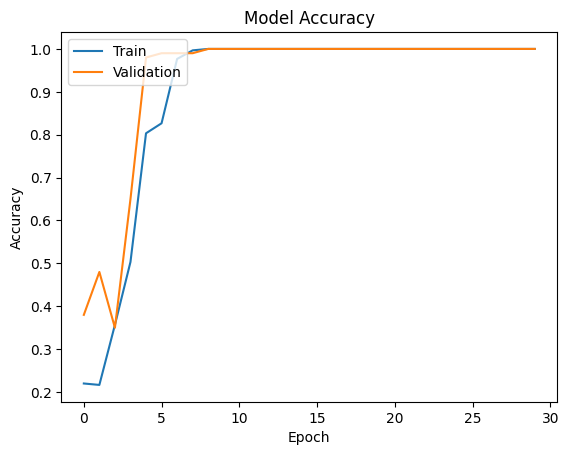

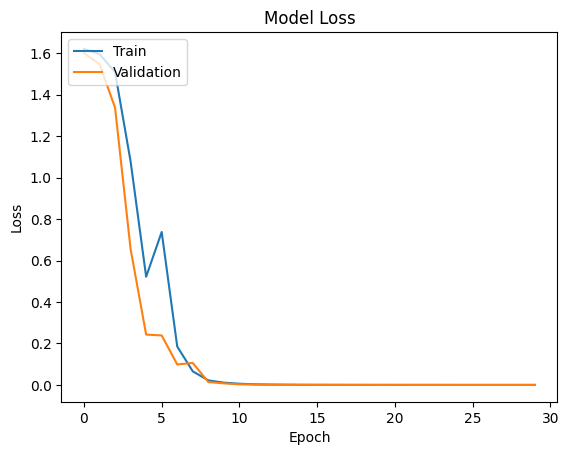

In [ ]:
# Plot training & validation accuracy values
plt.plot(tilted_T_cnn_history.history['accuracy'])
plt.plot(tilted_T_cnn_history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(tilted_T_cnn_history.history['loss'])
plt.plot(tilted_T_cnn_history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
tilted_T_cnn_predictions = cnn_model.predict(X_tilted_T_test_img)
# Apply argmax to the predictions to get the class labels
tilted_T_cnn_predicted_labels = np.argmax(tilted_T_cnn_predictions, axis=1)

4/4 [==============================] - 0s 68ms/step


In [ ]:
cnn_fpr = dict()
cnn_tpr = dict()
cnn_roc_auc = dict()

for i in range(n_classes):
    cnn_fpr[i], cnn_tpr[i], _ = roc_curve(Y_tilted_T_test_img[:, i], tilted_T_cnn_predictions[:, i])
    cnn_roc_auc[i] = roc_auc_score(Y_tilted_T_test_img[:, i], tilted_T_cnn_predictions[:, i])

# Aggregate the results to get a sense of the overall performance
# This is typically done by averaging the ROC AUC values
tilted_T_cnn_mean_auc = np.mean(list(cnn_roc_auc.values()))

print(f'Mean AUC: {tilted_T_cnn_mean_auc}')

Mean AUC: 1.0


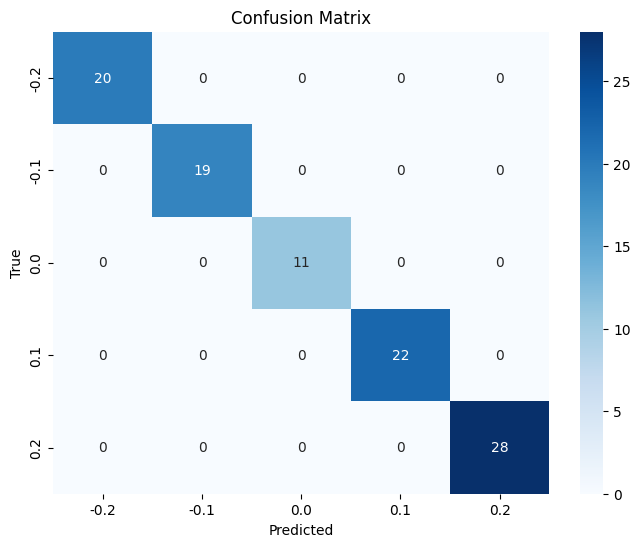

In [ ]:
# Create a confusion matrix
cm = confusion_matrix(tilted_T_classes[np.argmax(Y_tilted_T_test_img, axis=1)], tilted_T_classes[tilted_T_cnn_predicted_labels])

# Display the confusion matrix using a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=[-0.2,-0.1,0.0,0.1,0.2], yticklabels=[-0.2,-0.1,0.0,0.1,0.2])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
cnn_model.save(f'{model_path}/{tilted_T_model_cnn}')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Course Descriptor

### Load CSV file from the folder

In [ ]:
# Load CSV file data into dataframe
def load_csv(location):
  csv_file_path = os.path.join(location, csv_file_name)

  # Read the CSV file into a DataFrame
  df = pd.read_csv(csv_file_path)

  return df


In [ ]:
# Global Section to hold
# 1. Dataset location  - location
# 2. Labels - cd_input_data

location_ref = int(input("Enter 1 for \'input\' folder, 2 for \'tmp_skewed\' folder or 3 for \'tmp_tilt\' folder: "))

match location_ref:
  case 1:
    location = input_path
  case 2:
    location = tmp_skewed_path
  case 3:
    location = tmp_tilt_path

cd_input_data = load_csv(location)

Enter 1 for 'input' folder, 2 for 'tmp_skewed' folder or 3 for 'tmp_tilt' folder: 2


### Load the images and prepare for CNN

In [ ]:
fft_cd_images = []
for row in cd_input_data.itertuples():
  img = cv2.imread(f'{location}/{row.FILE_NAME}.png')
  img = cv2.resize(img,(400,566))
  img = img[:,:,0]
  img = denoise_tv_chambolle(img, weight=1.0, multichannel=0)
  f = cv2.dft(np.float32(img))
  fshift = np.fft.fftshift(f)
  f_abs = np.abs(fshift) + 1.0 # shift to avoid np.log(0) = nan
  f_img = 20 * np.log(f_abs)
  fft_cd_images.append( f_img )
  #cv2.imwrite(path+'/processed/'+names[i], f_img)

<ipython-input-26-c818ea35a85f>:6: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img = denoise_tv_chambolle(img, weight=1.0, multichannel=0)


In [ ]:
# Get images into tensor form
cd_image_arr = [ tf.keras.preprocessing.image.img_to_array(fft_cd_images[i])
for i in range(len(fft_cd_images) )]

# get pixel dimensions of image
img_height = cd_image_arr[0].shape[0]
img_width =  cd_image_arr[0].shape[1]

print(f'image height: {img_height} width: {img_width}')

# Training and test image stacks
X_cd = tf.stack(cd_image_arr, axis=0, name='test_set')

pixel_count = img_height * img_width

# Reshape to 3D Tensor
X_cd = np.array(X_cd).reshape(len(fft_cd_images), pixel_count)

# Normalise pixel values
X_cd /= 255



# Check shape of each tensor
print(X_cd.shape)


image height: 566 width: 400
(91, 226400)


In [ ]:
# Load the model
model_pred = load_model(f'{model_path}/{model_name}')

In [ ]:
print("Total Params:", model.count_params())
model_pred.summary()

Total Params: 116973579
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               115917312 
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 512)               262656    
                                                                 
 dense_3 (Dense)             (None, 512)               262656    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_4 (Dense)             (None, 512)               262656    
                                                                 
 dropout_1 (Dropout)         (No

In [ ]:
cd_predictions = model.predict(X_cd)
print(cd_predictions)

3/3 [==============================] - 0s 13ms/step
[[5.33340216e-01 2.38659263e-01 1.54389530e-01 ... 1.05764368e-03
  2.34258804e-03 8.84601753e-03]
 [9.70983624e-01 1.18868323e-02 8.37325933e-04 ... 8.74932957e-05
  4.52839522e-05 1.24004176e-02]
 [4.39282916e-02 8.07795599e-02 2.68794317e-03 ... 3.36689018e-02
  2.26837900e-02 4.73304778e-01]
 ...
 [9.10375535e-01 5.74878380e-02 2.38165278e-02 ... 4.71750973e-05
  7.95394153e-05 1.42910273e-03]
 [1.43888945e-08 1.25011510e-07 9.65220443e-06 ... 4.01394260e-07
  6.39545806e-06 1.41649235e-08]
 [8.94087970e-01 2.44691130e-03 1.28844640e-05 ... 1.34860857e-05
  1.78674111e-06 1.00373276e-01]]


In [ ]:
cd_input_data['PRED'] = classes[np.argmax(-cd_predictions, axis=1)]


cd_input_data.head(5)

,FILE_NAME,TYPE,VALUE,PRED
0,page_40,S,1.75,1
1,page_41,N,0.00,0
2,page_42,S,-1.34,0
3,page_43,N,0.00,0
4,page_44,S,0.28,0


<ipython-input-41-c2b34183f63c>:7: FutureWarning: `multichannel` is a deprecated argument name for `denoise_tv_chambolle`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img = denoise_tv_chambolle(img, weight=1.0, multichannel=0)


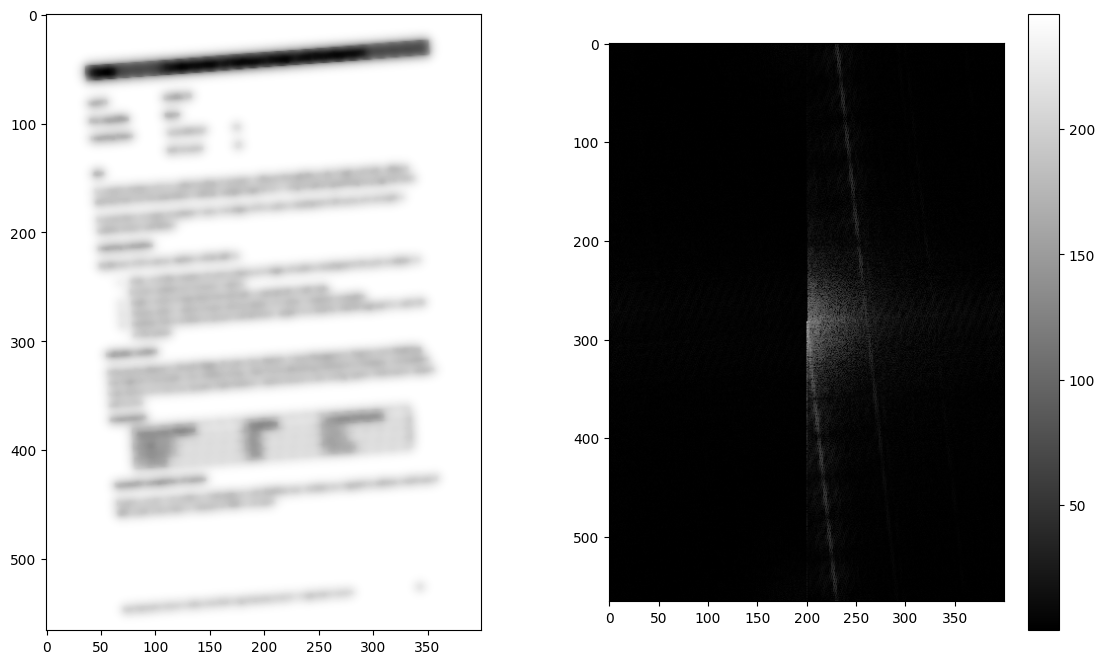

In [ ]:
eg_img = location +'/page_50.png'
img = cv2.imread(eg_img)
img = cv2.resize(img,(400,566))
img = img[:,:,0] #zeroth component is the red from RGB channel ordering


img = denoise_tv_chambolle(img, weight=1.0, multichannel=0)

f = cv2.dft(np.float32(img))
fshift = np.fft.fftshift(f)
f_abs = np.abs(fshift) + 1.0
f_img = 20 * np.log(f_abs)

plt.figure(figsize=(14,8))
plt.subplot(121),plt.imshow(img, 'gray')
plt.subplot(122),plt.imshow(f_img, 'gray')
#os.system('mkdir -p ./processed')
#cv2.imwrite(path+'/processed/'+names[18], f_img)
plt.colorbar()
plt.show()

In [ ]:
np.sum(np.square(np.round(np.array(cd_input_data.VALUE),2) - np.round((np.array(cd_input_data.PRED)),2)))/len(cd_input_data)

3.789006593406593

4.2 5
1.75 1
4.18 5


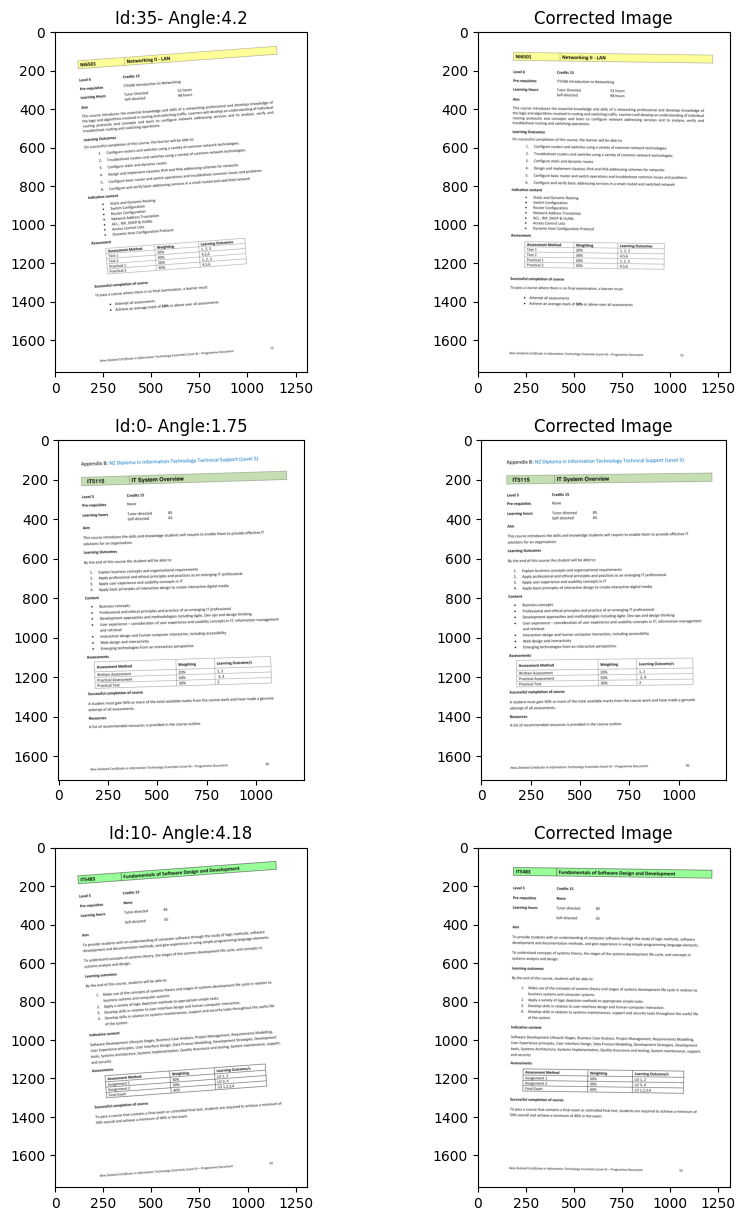

In [ ]:
# get random image and label names
def get_random_cd_img(r=[0, 499]):
    id = random.randint(r[0], r[1])
    sample_image_path = os.path.join(location, f'{cd_input_data.iloc[id][0]}.png')
    sample_label = cd_input_data.iloc[id][2]
    pred_label = cd_input_data.iloc[id][3]
    return id, sample_image_path, sample_label, pred_label

# display image
def display_cd_image(path=None, title=None):
    if path is not None:
        img = Image.open(path)

    plt.imshow(img);
    plt.title(title)

def cd_display_image(img, title):
  plt.imshow(img)
  plt.title(title)

# Display random images
plt.figure(figsize=(10,15))
for i in range(1,7,2):
  id, sample_image_path, sample_label, pred_label = get_random_cd_img([0, len(cd_input_data)])
  print(sample_label, pred_label)

  sample_title = "Id:" + str(id) + '- Angle:' + str(sample_label)
  if sample_image_path is not None:
     img = imread(sample_image_path)

  ax = plt.subplot(3, 2, i)
  cd_display_image(img, sample_title)

  # Get the image dimensions
  height, width = img.shape[:2]

  # Calculate the rotation matrix
  rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), -(pred_label), 1)

  # Apply the rotation to the image
  corrected_image = cv2.warpAffine(img, rotation_matrix, (width, height), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT, borderValue=(255, 255, 255))

  ax = plt.subplot(3, 2, i+1)
  #img_corrected = cd_skewness_correction(img)
  cd_display_image(corrected_image, 'Corrected Image')

# Implementation of Prediction Functions based on Train Models

In [ ]:
# Implementation of MLP Model for Skewness
